In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings

RANDOM_SEED = 20090425

%matplotlib inline
sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
print(f'Running on PyMC3 v{pm.__version__} and Pandas v{pd.__version__}')

Running on PyMC3 v3.6 and Pandas v0.23.0


#### Import dependent variable (election results) and standardized regressors (there are 7 of them)

In [2]:
X_full = pd.read_json('https://gist.githubusercontent.com/AlexAndorra/612de4a4beef75a9e051784872bd0fe3/raw/8c5ddee6f7ba1ca8be546eab02fc78fb96f2893d/X_full.json')
X_full = X_full.set_index(['departement', 'date']).sort_index()
X_full.head()

climat_affaires  conf_menages  prix_gazole  inflation  \
departement date                                                                
ain         1992-03-22        -0.408263      0.315657    -1.460156   2.114784   
            1993-03-21        -2.228318      0.017579    -1.460156   1.110468   
            1994-03-20        -0.601886      0.116938    -1.249131   0.733849   
            1994-06-12         0.317823      0.514375    -1.249131   0.733849   
            1995-04-23         0.772837      0.812452    -1.284302   0.106152   

                             pib   net_app   chomage  
departement date                                      
ain         1992-03-22  0.323604 -0.286913 -1.852963  
            1993-03-21 -1.305343 -0.596907 -1.215907  
            1994-03-20 -0.363523  0.093029 -0.676859  
            1994-06-12  0.564591  0.179032 -0.578850  
            1995-04-23  0.183035  0.303641 -0.921881

In [3]:
dptmts_idx, dptmts_names = X_full.index.get_level_values(0).factorize(sort=True)
n_dptmts = len(dptmts_names)
_, n_regressors = X_full.shape
X_full.shape

(1889, 7)

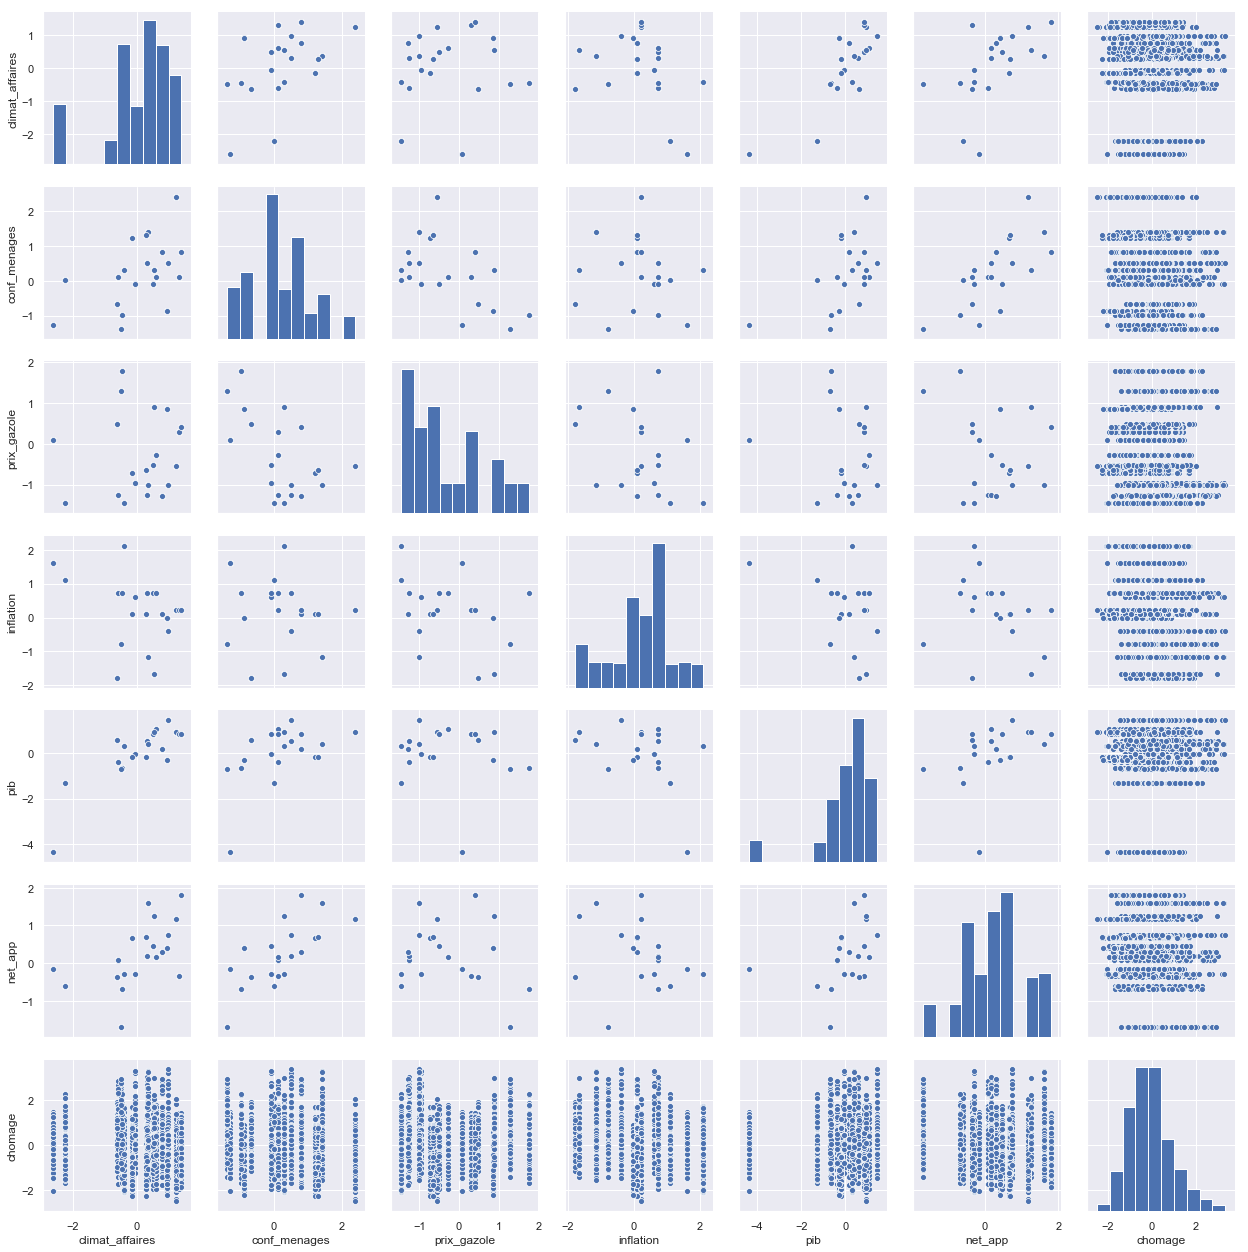

In [4]:
sns.pairplot(X_full);

In [5]:
results = pd.read_json('https://gist.githubusercontent.com/AlexAndorra/612de4a4beef75a9e051784872bd0fe3/raw/8c5ddee6f7ba1ca8be546eab02fc78fb96f2893d/Y_full.json')
results = results.set_index(['departement', 'date']).sort_index()
results.head()

farleft    left   green  center   right  farright  \
departement date                                                            
ain         1992-03-22   0.0482  0.1389  0.0741  0.2488  0.2064    0.1259   
            1993-03-21   0.0647  0.1182  0.0553  0.2560  0.2274    0.1483   
            1994-03-20   0.0698  0.1216  0.0548  0.2617  0.1476    0.1149   
            1994-06-12   0.0675  0.1339  0.0552  0.2548  0.2656    0.1211   
            1995-04-23   0.1104  0.2050  0.0391  0.1980  0.1923    0.1986   

                         other  
departement date                
ain         1992-03-22  0.1577  
            1993-03-21  0.1301  
            1994-03-20  0.2296  
            1994-06-12  0.1019  
            1995-04-23  0.0566

In [6]:
y_full = (results.copy() * 10000).astype(int) # transform proportions to multinomial observations
_, n_parties = y_full.shape
y_full.head()

farleft  left  green  center  right  farright  other
departement date                                                            
ain         1992-03-22      482  1389    741    2488   2064      1259   1577
            1993-03-21      647  1182    553    2560   2274      1483   1301
            1994-03-20      698  1216    548    2617   1476      1149   2296
            1994-06-12      675  1339    552    2548   2656      1211   1019
            1995-04-23     1104  2050    391    1980   1923      1986    566

In [7]:
X_full.sample(5)

,,climat_affaires,conf_menages,prix_gazole,inflation,pib,net_app,chomage
departement,date,,,,,,,
jura,2009-06-07,-2.615564,-1.274089,0.087362,1.612626,-4.371818,-0.146251,-0.676859
hautemarne,1992-03-22,-0.408263,0.315657,-1.460156,2.114784,0.323604,-0.286913,-0.676859
orne,2009-06-07,-2.615564,-1.274089,0.087362,1.612626,-4.371818,-0.146251,-0.039803
mayenne,1992-03-22,-0.408263,0.315657,-1.460156,2.114784,0.323604,-0.286913,-1.656945
somme,2001-03-11,1.237532,2.402197,-0.545714,0.231691,0.962999,1.172080,0.450240


Reduce to just one observation per cluster for testing

In [8]:
idx = pd.IndexSlice
X_trunc = X_full.loc[idx[:, '2012-04-22'], :]
y_trunc = y_full.loc[idx[:, '2012-04-22'], :]

In [9]:
# make sure there is no missing data here
groupX = X_full.loc[idx['seinemaritime',:], :].iloc[:, :n_regressors-1].values

Ndpt = len(np.unique(dptmts_idx))
date_idx, date_names = X_full.index.get_level_values(1).factorize(sort=True)

In [10]:
with pm.Model() as hier_model:
    dpt_interp = pm.Normal('dpt_interp', 0., 1., shape=(Ndpt, n_parties-1))
    fixed_effect = pm.Normal('fixed', 0., 1., shape=(n_regressors-1, n_parties-1))
    random_effect = pm.Normal('random', 0., 1., shape=n_parties-1)
    
    results_est = dpt_interp[dptmts_idx] +\
                tt.dot(groupX, fixed_effect)[date_idx]+\
                X_full['chomage'].values[:, None]*random_effect
    results_est = tt.concatenate(tensor_list=[results_est, 
                                              tt.zeros((X_full.shape[0], 1))],
                                 axis=1)
    
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    likelihood = pm.Multinomial('likelihood',
                                n=y_full.sum(axis=1),
                                p=probs,
                                observed=y_full.values)

    trace = pm.sample(1000, tune=1000, cores=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [random, fixed, dpt_interp]
Sampling 4 chains: 100%|██████████| 8000/8000 [07:27<00:00,  4.03draws/s]
The acceptance probability does not match the target. It is 0.9309155424475302, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9457147034743725, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
pm.traceplot(trace, var_names=['fixed', 'random']);

In [ ]:
pm.summary(trace, varnames=['dpt_interp', 'fixed', 'random'])

#### Simple univariate model: samples, but very inefficiently and doesn't converge

In [21]:
with pm.Model() as simple_model:
    a = pm.Normal('a', mu=0., sd=1., shape=(1, n_parties))
    b = pm.Normal('b', mu=0., sd=1., shape=(1, n_parties))

    results_est = a + b * np.expand_dims(X_trunc.chomage, axis=1)
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    likelihood = pm.Multinomial('likelihood',
                                n=y_trunc.sum(axis=1), 
                                p=probs, 
                                observed=y_trunc.values)

    trace = pm.sample(2000, tune=1000, cores=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:50<00:00, 52.04draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


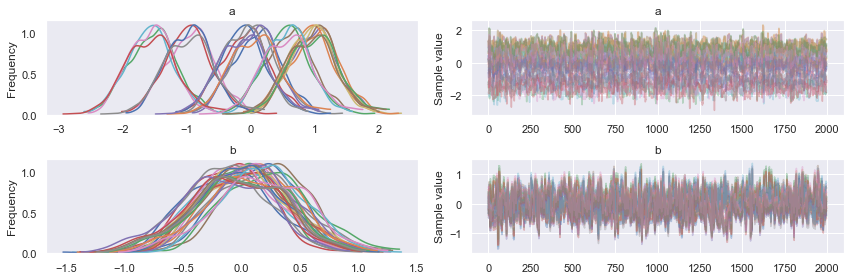

In [22]:
pm.traceplot(trace, varnames=['a', 'b']);

#### Hierarchical univariate model: samples but very inefficiently and doesn't converge

In [23]:
with pm.Model() as oneelec_univ:

    mu_a = pm.Normal('mu_a', mu=0., sd=1.)
    sigma_a = pm.HalfNormal('sigma_a', 1.)
    mu_b = pm.Normal('mu_b', mu=0., sd=1.)
    sigma_b = pm.HalfNormal('sigma_b', 1.)

    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=(1, n_parties))
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=(1, n_parties))

    results_est = a + b * np.expand_dims(X_trunc.chomage, axis=1)
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    likelihood = pm.Multinomial('likelihood',
                                n=y_trunc.sum(axis=1),
                                p=probs,
                                observed=y_trunc.values)

    trace = pm.sample(2000, tune=1000, cores=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 12000/12000 [13:40<00:00,  8.93draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


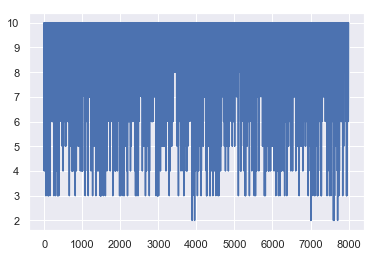

In [27]:
plt.plot(trace.get_sampler_stats('depth'))

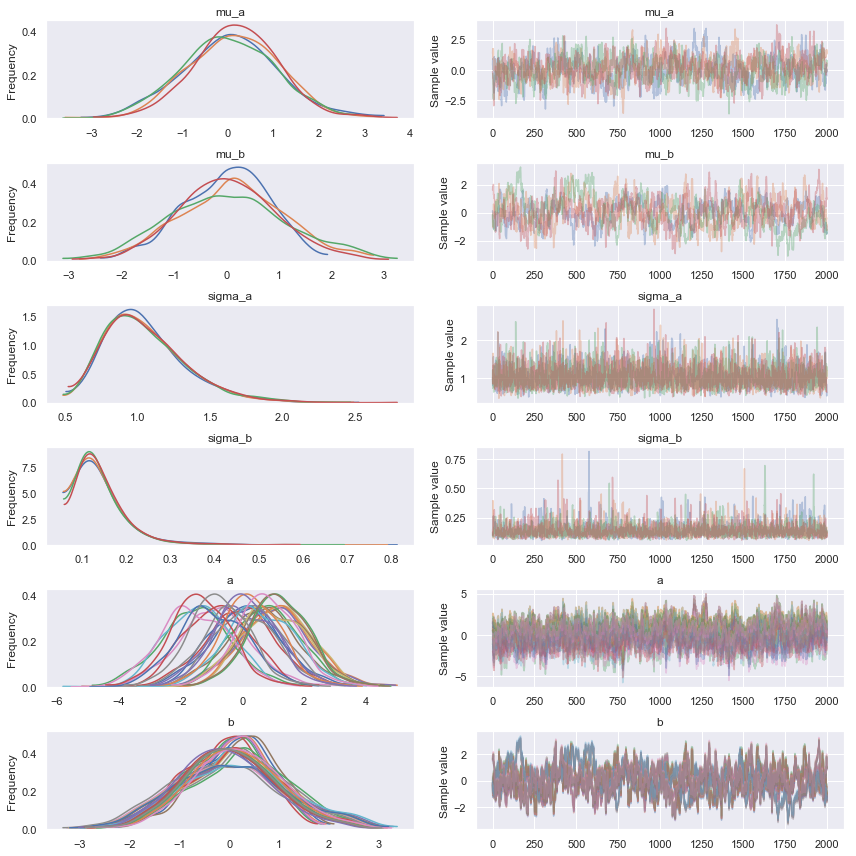

In [24]:
pm.traceplot(trace, varnames=['mu_a', 'mu_b',
                              'sigma_a', 'sigma_b',
                              'a', 'b']);

#### Non-centered version of previous model: doesn't sample ("*Mass matrix contains zeros on the diagonal*")

In [28]:
with pm.Model() as oneelec_univ_nc:

    mu_a = pm.Normal('mu_a', mu=0., sd=1.)
    sigma_a = pm.HalfNormal('sigma_a', 1.)
    mu_b = pm.Normal('mu_b', mu=0., sd=1.)
    sigma_b = pm.HalfNormal('sigma_b', 1.)

    a = pm.Normal('a', mu=0., sd=1., shape=(1, n_parties))
    b = pm.Normal('b', mu=0., sd=1., shape=(1, n_parties))

    results_est = (mu_a + a*sigma_a) + (mu_b + b*sigma_b) * np.expand_dims(X_trunc.chomage, axis=1)
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    likelihood = pm.Multinomial('likelihood',
                                n=y_trunc.sum(axis=1),
                                p=probs,
                                observed=y_trunc.values)

    trace = pm.sample(2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 12000/12000 [13:12<00:00, 15.14draws/s]
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparamete

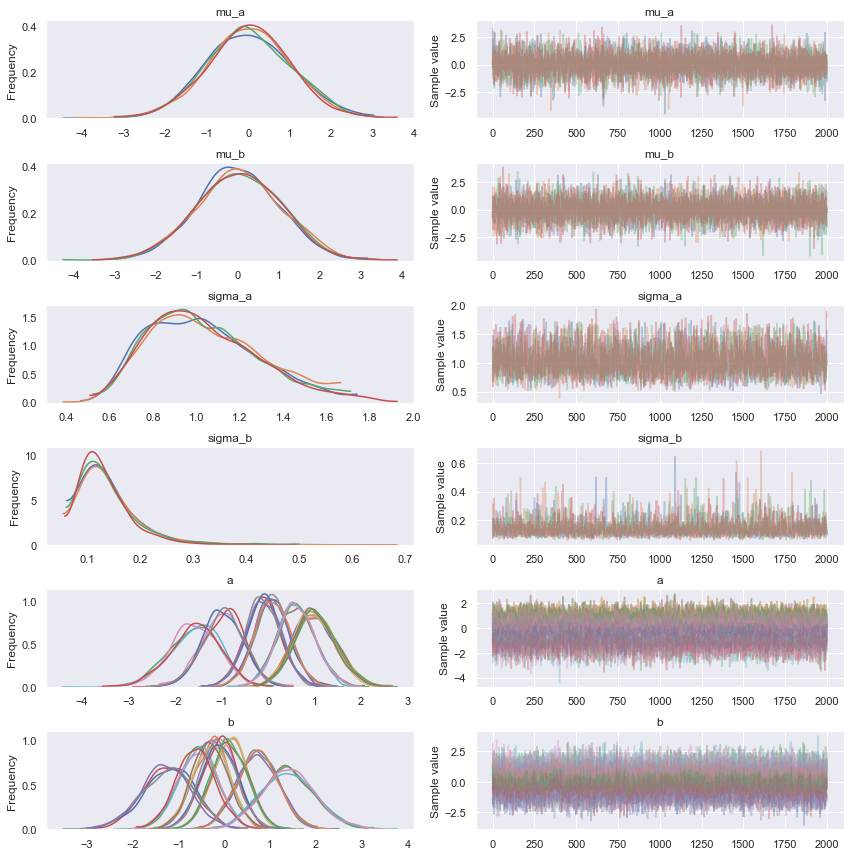

In [29]:
pm.traceplot(trace, varnames=['mu_a', 'mu_b',
                              'sigma_a', 'sigma_b',
                              'a', 'b']);

#### Hierarchical *multivariate* model: samples but very inefficiently and doesn't converge

In [ ]:
with pm.Model() as oneelec_multiv:
    
#     mu_a = pm.Normal('mu_a', mu=0., sd=1.)
#     sigma_a = pm.HalfNormal('sigma_a', 1.)
#     mu_b = pm.Normal('mu_b', mu=0., sd=1.)
#     sigma_b = pm.HalfNormal('sigma_b', 1.)
    
    a = pm.Normal('a', mu=0., sd=1., shape=(1, n_parties))
    b = pm.Normal('b', mu=0., sd=1., shape=(1, n_parties, n_regressors))

    results_est = a + pm.math.sum(b * np.expand_dims(X_trunc, axis=1), axis=2)
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    likelihood = pm.Multinomial('likelihood',
                                n=y_trunc.sum(axis=1),
                                p=probs,
                                observed=y_trunc.values)
    
    trace = pm.sample(2000, tune=1000, cores=4)

In [ ]:
pm.traceplot(trace, varnames=['a', 'b']);

#### Hierarchical multivariate model with whole data (*several observations per county*): samples but very inefficiently and doesn't converge

In [ ]:
with pm.Model() as multi_elec_multiv:

    mu_a = pm.Normal('mu_a', mu=2., sd=1.)
    sigma_a = pm.HalfNormal('sigma_a', 2.5)
    mu_b = pm.Normal('mu_b', mu=3.9, sd=1.)
    sigma_b = pm.HalfNormal('sigma_b', 2.5)

    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=(n_dptmts, n_parties))
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=(n_dptmts, n_parties, n_regressors))

    results_est = a[dptmts_idx, :] + pm.math.sum(b[dptmts_idx, :, :] * np.expand_dims(X_full, axis=1), axis=2)
    p = pm.Deterministic('p', tt.nnet.softmax(results_est))
    likelihood = pm.Multinomial('likelihood',
                                n=y_full.sum(axis=1),
                                p=probs,
                                observed=y_full.values)

    trace = pm.sample(2000, tune=1000, cores=4, random_seed=RANDOM_SEED)